In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset

In [2]:
feature = pd.read_pickle("feature.pkl")
target = pd.read_pickle("target.pkl")

In [3]:
x_train, x_test, y_train, y_test = train_test_split(feature, target, test_size=0.1, random_state=42, stratify=target)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.1, random_state=42, stratify=y_test)

In [4]:
x_train.shape, x_valid.shape, x_test.shape

((8100, 15000), (810, 15000), (90, 15000))

In [5]:
x_train = torch.tensor(x_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
x_valid = torch.tensor(x_valid.values, dtype=torch.float32)
y_valid = torch.tensor(y_valid.values, dtype=torch.long)
x_test = torch.tensor(x_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.long)

In [6]:
# 데이터셋 생성
import torch.utils.data.dataloader as dataloader
import torch.utils.data.dataset as dataset

class MyDataset(dataset.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [7]:
dataset_train = MyDataset(x_train, y_train)
dataset_test = MyDataset(x_test, y_test)
dataset_valid = MyDataset(x_valid, y_valid)

In [8]:
x_train.shape

torch.Size([8100, 15000])

In [9]:
class model(nn.Module): # 가중치 초기화 
    def __init__(self):
        super(model, self).__init__()
        self.fc1 = nn.Linear(15000, 4000)
        self.fc2 = nn.Linear(4000, 9)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
model2 = model()
for name, child in model2.named_children():
    nn.init.kaiming_normal_(child.weight)
optimizer = optim.RAdam(model2.parameters())
criterion = nn.CrossEntropyLoss()

train_loader = dataloader.DataLoader(dataset_train, batch_size=100, shuffle=True, drop_last=True)
test_loader = dataloader.DataLoader(dataset_test, batch_size=100, shuffle=True, drop_last=True)
valid_loader = dataloader.DataLoader(dataset_valid, batch_size=100, shuffle=True, drop_last=True)

In [11]:
from torchmetrics.functional.classification import accuracy, f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
model2.train()
valid_score=[]
train_score=[]

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

for epoch in range(15):
    
    for x,y in train_loader:
        output = model2(x)
        loss = criterion(output, y.squeeze())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():        
        print(f"================================={epoch}=================================")
        output = model2(x_train)
        acc = accuracy(output, y_train.squeeze(), task="multiclass", num_classes=9, average="macro")
        f1 = f1_score(output, y_train.squeeze(), task="multiclass", num_classes=9, average="macro")
        train_score.append([acc, f1])
        print(f"train => acc : {acc}, f1 : {f1}")
        
        
        output = model2(x_valid)
        print(f"=================================valid score=================================")
        acc2 = accuracy(output, y_valid.squeeze(), task="multiclass", num_classes=9, average="macro")
        f12 = f1_score(output, y_valid.squeeze(), task="multiclass", num_classes=9, average="macro")
        valid_score.append([acc2, f12])
        print(f"valid => acc : {acc2}, f1 : {f12}")
    
    scheduler.step(loss)
    if scheduler.num_bad_epochs >= scheduler.patience:
        print(f"Early stopping at epoch {epoch}")
        break


=================================0=================================
train => acc : 0.5618517994880676, f1 : 0.5552995800971985
=================================valid score=================================
valid => acc : 0.5444445013999939, f1 : 0.5394803285598755
=================================1=================================
train => acc : 0.6479012370109558, f1 : 0.6368308663368225
=================================valid score=================================
valid => acc : 0.5901234745979309, f1 : 0.5776592493057251
=================================2=================================
train => acc : 0.7575308680534363, f1 : 0.7574297785758972
=================================valid score=================================
valid => acc : 0.6395061016082764, f1 : 0.6391874551773071
=================================3=================================
train => acc : 0.7995061874389648, f1 : 0.8003870248794556
=================================valid score=================================
val

In [12]:
torch.save(model2,"./RAdam_model.pth")

In [13]:
import torch
from torchmetrics.functional.classification import accuracy, f1_score
model2=model()
model2 = torch.load("./RAdam_model.pth")

output = model2(x_test)
print(f"=================================test score=================================")
print(accuracy(output, y_test.squeeze(), task="multiclass", num_classes=9, average="macro"))
print(f1_score(output, y_test.squeeze(), task="multiclass", num_classes=9, average="macro"))

=================================test score=================================
tensor(0.7000)
tensor(0.6986)


In [14]:
train_acc = np.array(train_score)[:,0]
train_f1 = np.array(train_score)[:,1]

valid_acc = np.array(valid_score)[:,0]
valid_f1 = np.array(valid_score)[:,1]

In [15]:
train_score, valid_score

([[tensor(0.5619), tensor(0.5553)],
  [tensor(0.6479), tensor(0.6368)],
  [tensor(0.7575), tensor(0.7574)],
  [tensor(0.7995), tensor(0.8004)],
  [tensor(0.8023), tensor(0.8029)],
  [tensor(0.8504), tensor(0.8476)],
  [tensor(0.8656), tensor(0.8654)],
  [tensor(0.9022), tensor(0.9028)],
  [tensor(0.9347), tensor(0.9343)],
  [tensor(0.9214), tensor(0.9213)],
  [tensor(0.9415), tensor(0.9415)],
  [tensor(0.9404), tensor(0.9403)],
  [tensor(0.9649), tensor(0.9649)],
  [tensor(0.9614), tensor(0.9613)],
  [tensor(0.9502), tensor(0.9501)]],
 [[tensor(0.5444), tensor(0.5395)],
  [tensor(0.5901), tensor(0.5777)],
  [tensor(0.6395), tensor(0.6392)],
  [tensor(0.6568), tensor(0.6563)],
  [tensor(0.6272), tensor(0.6297)],
  [tensor(0.6605), tensor(0.6584)],
  [tensor(0.6691), tensor(0.6697)],
  [tensor(0.6704), tensor(0.6690)],
  [tensor(0.7173), tensor(0.7147)],
  [tensor(0.6840), tensor(0.6845)],
  [tensor(0.7198), tensor(0.7208)],
  [tensor(0.7321), tensor(0.7327)],
  [tensor(0.7481), tensor(0

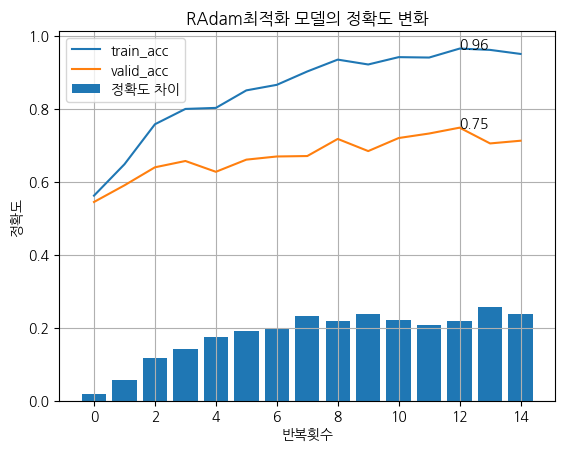

In [16]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

plt.plot(train_acc, label="train_acc")
plt.plot(valid_acc, label="valid_acc")
plt.bar(range(15),train_acc-valid_acc, label="정확도 차이")
plt.legend()
plt.title("RAdam최적화 모델의 정확도 변화")
plt.text(np.argmax(train_acc), np.max(train_acc), f"{np.max(train_acc):.2f}")
plt.text(np.argmax(valid_acc), np.max(valid_acc), f"{np.max(valid_acc):.2f}")
plt.xlabel("반복횟수")
plt.ylabel("정확도")
plt.grid()
plt.show()

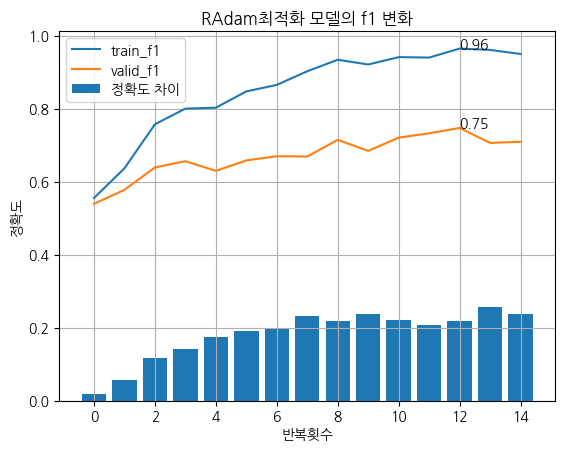

In [17]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

plt.plot(train_f1, label="train_f1")
plt.plot(valid_f1, label="valid_f1")
plt.bar(range(15),train_acc-valid_acc, label="정확도 차이")
plt.legend()
plt.title("RAdam최적화 모델의 f1 변화")
plt.xlabel("반복횟수")
plt.ylabel("정확도")
plt.text(np.argmax(train_f1), np.max(train_f1), f"{np.max(train_f1):.2f}")
plt.text(np.argmax(valid_f1), np.max(valid_f1), f"{np.max(valid_f1):.2f}")
plt.grid()
plt.show()

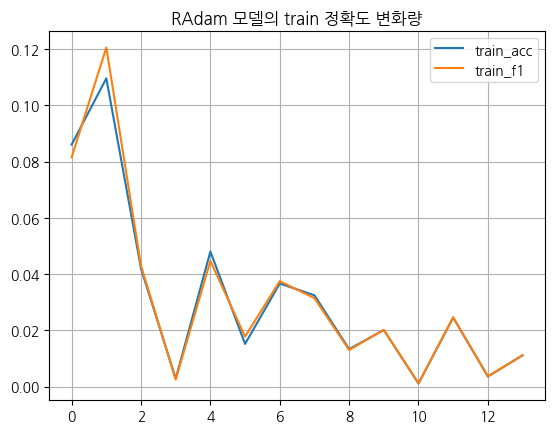

In [18]:
plt.plot(np.abs(train_acc[:-1]-train_acc[1:]), label="train_acc")
plt.plot(np.abs(train_f1[:-1]-train_f1[1:]), label="train_f1")
plt.title("RAdam 모델의 train 정확도 변화량")
plt.legend()
plt.grid()
plt.show()

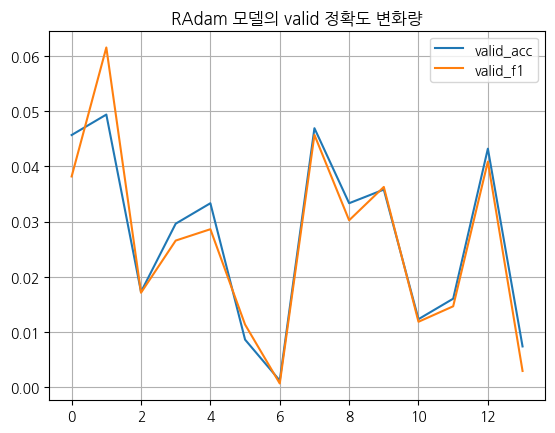

In [19]:
plt.plot(np.abs(valid_acc[:-1]-valid_acc[1:]), label="valid_acc")
plt.plot(np.abs(valid_f1[:-1]-valid_f1[1:]), label="valid_f1")
plt.title("RAdam 모델의 valid 정확도 변화량")
plt.legend()
plt.grid()
plt.show()